In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Radon transform
Useful links:
* https://en.wikipedia.org/wiki/Radon_transform
* http://scikit-image.org/docs/dev/auto_examples/transform/plot_radon_transform.html

If $f:\mathbb R^2\to\mathbb R$ is compactly supported, the **Radon transform** (RT) $Rf$ is defined on the set $\Sigma$ of straight lines $L\subset \mathbb R$ by $$Rf(L)=\int_Lf(\mathbf x)d\mathbf x.$$

The line $L$ can be parameterized by its distance $s$ to the origin and the angle $\alpha$ that $L$ makes with the $y$ axis. Then $$Rf(\alpha, s) = \int_{-\infty}^\infty f (x(z),y(z))dz = \int_{-\infty}^\infty f(z\sin\alpha+s\cos\alpha, -z\cos\alpha+s\sin\alpha) dz.$$


<img src='https://upload.wikimedia.org/wikipedia/commons/5/5d/Radon_transform.png' width="300"/>

Here, $s$ may be negative. The line $(\alpha, s)$ is identical to the line $(-\alpha, -s)$.

### Examples: Shepp-Logan phantom and a rectangle

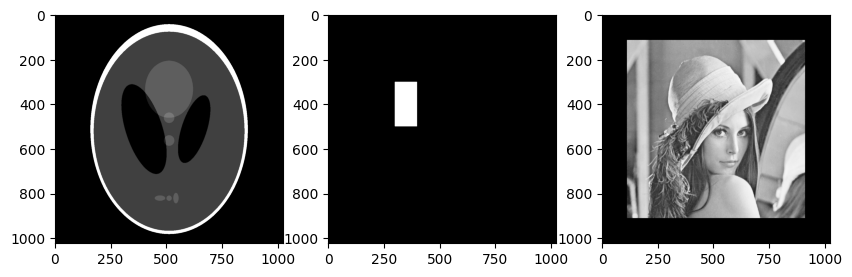

In [ ]:
from skimage.io import imread
from skimage.transform import resize

N = 1024

plt.figure(figsize=(10,7))

ImOrigL = []

for k in range(3):
    plt.subplot(1,3,k+1)
    if k == 0:
        ImOrigL.append(imread('https://upload.wikimedia.org/wikipedia/commons/e/e5/Shepp_logan.png',
                              as_gray=True)/255.) # rescale to the interval [0,1]
    elif k == 1:
        ImOrigL.append(np.zeros((N,N)))
        ImOrigL[-1][300:500,300:400] = 1
    else:
        ImOrigL.append(np.zeros((N,N)))
        s = 800
        im = resize(imread('https://www.cosy.sbg.ac.at/~pmeerw/Watermarking/lena_gray.gif',
                           as_gray=True)/255., (s,s)) # resize to s x s
        #im = resize(imread('lena.gif', as_gray=True)/255., (s,s)) # resize to s x s
        ImOrigL[-1][(N-s)//2:(N-s)//2+s, (N-s)//2:(N-s)//2+s] = im
    assert ImOrigL[-1].shape == (N,N)
    plt.imshow(ImOrigL[-1], cmap=plt.cm.Greys_r)

plt.show()

We implement RT by first rotating the image, and then summing the values along the vertical axis.

To rotate the image, we use a standard `scikit-image` function.

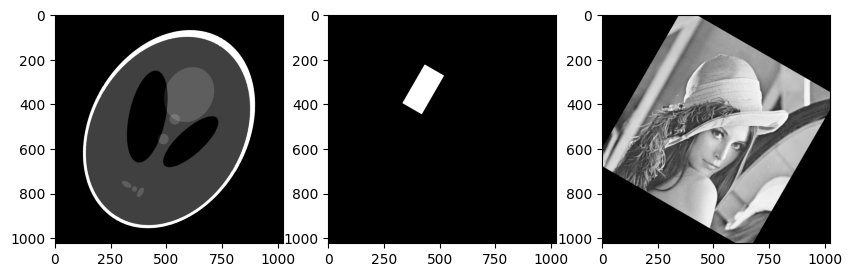

In [ ]:
from skimage.transform import rotate

plt.figure(figsize=(10,7))

for k in range(3):
    plt.subplot(1,3,k+1)
    f_rot = rotate(ImOrigL[k], -30)
    plt.imshow(f_rot, cmap=plt.cm.Greys_r)

plt.show()

We compute RT on the rectangle $(s,\alpha)\in\big[-\frac{N}{2},\frac{N}{2}\big]\times[0^\circ,180^\circ]$

In [ ]:
def radon(f, Nangles=200): # Nangles: the angle discretization parameter
    angles = np.linspace(0, 180, Nangles, endpoint=False)
    assert f.shape[0] == f.shape[1] and f.shape[0] == N
    Rf = np.zeros((N, len(angles)))
    for n, alpha in enumerate(angles):
        f1 = rotate(f, -alpha)
        Rf[:,n] = np.sum(f1, axis=0)
    return Rf

The RT of an image is called *the sinogram*.

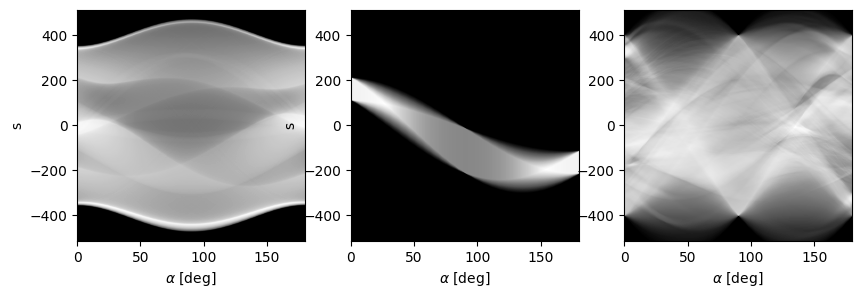

In [ ]:
plt.figure(figsize=(10,3))

ImRadonL = []
for k in range(3):
    plt.subplot(1,3,k+1)
    Rf = radon(ImOrigL[k])
    ImRadonL.append(Rf)
    plt.imshow(Rf, cmap=plt.cm.Greys_r, aspect='auto', extent=[0,180,-N/2,N/2])
    plt.xlabel('$\\alpha$ [deg]')
    plt.ylabel('s')

plt.show()

## Fourier slice theorem

Having the Radon-transformed function (the sinogram), can we reconstruct the original function?

Yes, we can, for example using the relation between Radon and Fourier transforms.

**Theorem.** Write $Rf(\alpha, s)\equiv R_\alpha f(s)$ (i.e., as an $\alpha$-family of $s$-transforms). Then, for each fixed $\alpha$,

$$\widehat{R_\alpha f}(\sigma)=\widehat{f}(\sigma \mathbf{n}(\alpha)),$$

where $\mathbf{n}(\alpha) = (\cos\alpha, \sin\alpha)$. Here, $\widehat{R_\alpha f}$ denotes the 1D FT of $R_\alpha f$ w.r.t. $s,$ while $\widehat{f}$ denotes the 2D FT of $f$.

**Proof.**
Using the substitution $x=z\sin\alpha+s\cos\alpha, y=-z\cos\alpha+s\sin\alpha$:

$$\begin{align*}
\widehat{f}(\sigma \mathbf{n}(\alpha))
& =\int_{-\infty}^\infty\int_{-\infty}^\infty f(x,y)e^{-i\sigma (x\cos\alpha+y\sin\alpha)}dxdy\\
& =\int_{-\infty}^\infty\int_{-\infty}^\infty f(z\sin\alpha+s\cos\alpha, -z\cos\alpha+s\sin\alpha)e^{-i\sigma s}dzds\\
& = \int_{-\infty}^\infty R_\alpha f(\sigma)e^{-i\sigma s}ds\\
& = \widehat{R_\alpha f}(\sigma)
\end{align*}$$ $\square$

This theorem implies that if we know $Rf$ then we can, in principle, recover $f$ as follows. First, we reconstruct $\widehat f$ on each line $\{\sigma \mathbf{n}(\alpha)\}_{\sigma\in\mathbb R}$ from $\widehat{R_\alpha f}$ using the inverse 1D FT; by considering all such lines we find $\widehat f$ everywhere on $\mathbb R^2$. Then we can recover $f$ from $\widehat f$ using the inverse 2D FT.

However, more convenient ways to reconstruct the original image exist.

## Dual Radon transform
The dual RT $R^*$ transforms a function $g:\Sigma\to\mathbb R$ to a function on $\mathbb R^2$:

$$R^*g(\mathbf x)=\int_{L:\mathbf x\in L}g(L)dL=\frac{1}{\pi}\int_{0}^{\pi}g(L_{\mathbf x,\alpha})d\alpha,$$

where $L_{\mathbf x,\alpha}$ is the line going through $\mathbf x$ and making the angle $\alpha$ with the $y$ axis.

Why do we call $R^*$ *dual*? Let $f:\mathbb R^2\to \mathbb R$ and $g:\Sigma\to \mathbb R$.
Then

$$\begin{align*}
\langle f,R^* g\rangle_{L^2(\mathbb R^2)}
&=\int_{\mathbb R^2} f(\mathbf x) (R^*g)(\mathbf x)d^2\mathbf x\\
&=\frac{1}{\pi}\int_{\mathbb R^2}\int_0^{\pi} f(\mathbf x) g(L_{\mathbf x,\alpha})d^2\mathbf xd\alpha\\
&=\frac{1}{\pi}\int_{\mathbb R}\int_{\mathbb R}\int_0^{\pi} f(z\sin\alpha+s\cos\alpha, -z\cos\alpha+s\sin\alpha) g(s,\alpha)dsdzd\alpha\\
&=\frac{1}{\pi}\int_{\mathbb R}\int_0^{\pi} (Rf)(s,\alpha) g(s,\alpha)dsd\alpha\\
&=\langle Rf, g\rangle_{L^2(\Sigma)},
\end{align*}$$

where we substituted $\mathbf x=(z\sin\alpha+s\cos\alpha, -z\cos\alpha+s\sin\alpha)$ and defined the scalar product in $L^2(\Sigma)$ by

$$\langle g_1, g_2\rangle_{L^2(\Sigma)}=\frac{1}{\pi}\int_{\mathbb R}\int_0^{\pi} g_1(s,\alpha) g_2(s,\alpha)dsd\alpha.$$

In [ ]:
def radon_dual(Rf):
    assert Rf.shape[0] == N
    x = np.arange(N)
    X, Y = np.meshgrid(x-N/2, -(x-N/2))
    RdRf = np.zeros((N,N))
    angles = np.linspace(0, np.pi, Rf.shape[1], endpoint=False)
    for n,alpha in enumerate(angles):
        S = X*np.cos(alpha)+Y*np.sin(alpha)
        S = S.astype(int)
        S = np.clip(S+N//2, 0, N-1)
        RdRf += Rf[S,n]
    RdRf /= len(angles)
    return RdRf

## Approximate (blurred) reconstruction using dual RT (backprojection)
If we apply dual RT to the RT of an image, then we get a **blurred** version of the original image:

$$\begin{align*}
R^*Rf(x,y)&=\frac{1}{\pi}\int_{0}^{\pi}\int_{-\infty}^\infty  f(x+z\sin\alpha, y-z\cos\alpha) d\alpha dz \\
& = \frac{1}{\pi}\int_{0}^{2\pi}\int_{0}^\infty  f(x+r\sin\alpha, y-r\cos\alpha) d\alpha dr\\
& = \frac{1}{\pi}\int_{0}^{2\pi}\int_{0}^\infty  f(x+r\sin\alpha, y-r\cos\alpha)\frac{1}{r} rd\alpha dr\\
& = \frac{1}{\pi}\int_{-\infty}^{\infty}\int_{-\infty}^{\infty}  f(x-x_1, y-y_1)\frac{1}{\sqrt{x_1^2+y_1^2}} dx_1dy_1\\
& = (f*g)(x,y),
\end{align*}$$

where $g(x,y)=\frac{1}{\pi\sqrt{x^2+y^2}}.$

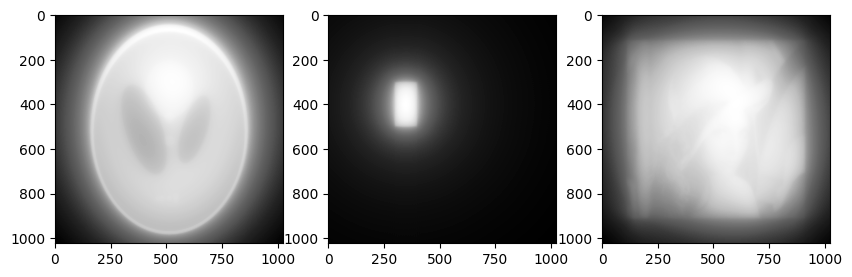

In [ ]:
plt.figure(figsize=(10,7))

ImRdRL = []
for k in range(3):
    plt.subplot(1,3,k+1)
    RdRf = radon_dual(ImRadonL[k])
    ImRdRL.append(RdRf)
    plt.imshow(RdRf, cmap=plt.cm.Greys_r)

plt.show()

## Hilbert transform
Given $f:\mathbb R\to\mathbb R$, define its Hilbert Transform (HT) $Hf:\mathbb R\to\mathbb R$ by:

$$Hf(t)=\frac{1}{\pi}\mathrm{p.v.}\int_{-\infty}^\infty \frac{f(\tau)}{t-\tau}d\tau=(f*h)(t),$$

where $h(t)=\frac{1}{\pi t}.$

**Exercise.** $\widehat{Hf}(p)=\widehat{f}(p)\cdot i\operatorname{sign}(p).$

## Exact reconstruction using Hilbert transform (filtered backprojection)
A reconstruction without blurring can be performed using HT.

Given a function $g:\Sigma\to\mathbb R$, i.e., $g(s,\alpha)$, let $H_s$ denote HT with respect to the variable $s$.

**Theorem.** $$\frac{1}{2}R^*H_s\frac{d}{ds}Rf=f.$$

**Proof.** It suffices to check that for any sufficiently good $f,g:\mathbb R^2\to\mathbb R$ we have

$$\Big\langle \frac{1}{2}R^*H_s\frac{d}{ds}Rf,g\Big\rangle_{L^2(\mathbb R^2)}=\langle f,g\rangle_{L^2(\mathbb R^2)}.$$

This can be proved as follows:

$$\begin{align*}
\Big\langle \frac{1}{2}R^*H_s\frac{d}{ds}Rf,g\Big\rangle_{L^2(\mathbb R^2)}
&=\Big\langle \frac{1}{2}H_s\frac{d}{ds}Rf,Rg\Big\rangle_{L^2(\Sigma)}\\
&=\frac{1}{2\pi}\int_{0}^\pi\int_{\mathbb R} \big(H_s\frac{d}{ds}Rf\big)(s) \cdot Rg(s)d\alpha ds\\
&=\frac{1}{4\pi^2}\int_{0}^\pi\int_{\mathbb R} \widehat{\big(H_s\frac{d}{ds}R_\alpha f\big)}(\sigma) \cdot \overline{\widehat{R_\alpha g}(\sigma)}d\alpha d\sigma\\
&=\frac{1}{4\pi^2}\int_{0}^\pi\int_{\mathbb R} |\sigma|\widehat{R_\alpha f}(\sigma) \cdot \overline{\widehat{R_\alpha g}(\sigma)}d\alpha d\sigma\\
&=\frac{1}{4\pi^2}\int_{0}^\pi\int_{\mathbb R} \widehat{f}(\sigma \mathbf{n}(\alpha)) \cdot \overline{\widehat{g}(\sigma \mathbf{n}(\alpha))}|\sigma|d\alpha d\sigma\\
&=\frac{1}{4\pi^2}\int_{\mathbb R}\int_{\mathbb R} \widehat{f}(p,q) \cdot \overline{\widehat{g}(p,q)}dpdq\\
&=\int_{\mathbb R}\int_{\mathbb R} f(x,y) \overline{g(x,y)}dxdy\\
&=\langle f,g\rangle_{L^2(\mathbb R^2)}
,\end{align*}$$

where we used the duality relation, the Fourier slice theorem, the property $\widehat{Hf}(p)=\widehat{f}(p)\cdot i\operatorname{sign}(p),$ and standard properties of FT.

$\square$

Thus, the inverse Randon transform can be written as $$R^{-1}=\frac{1}{2}R^*H_s\frac{d}{ds}.$$

In [ ]:
def ds(Rf):
    dRf = np.zeros_like(Rf)
    dRf[:-1] = Rf[1:]-Rf[:-1]
    dRf[-1] = Rf[-1]-Rf[-2]
    return dRf

def hilbert_s(Rf):
    assert Rf.shape[0] == N
    K = np.zeros((N-1,))
    K[:N//2-1] = -1./np.arange(N/2-1,0,-1)
    K[N//2:] = 1./np.arange(1,N/2)
    K /= np.pi
    hRf = np.zeros_like(Rf)
    for n in range(Rf.shape[1]):
        hRf[:,n] = np.convolve(Rf[:,n], K, 'same')
    return hRf

def radon_inv(Rf):
    return radon_dual(hilbert_s(ds(Rf)))/2.

Now we can reconstruct the original images without blurring:

Reconstructed:


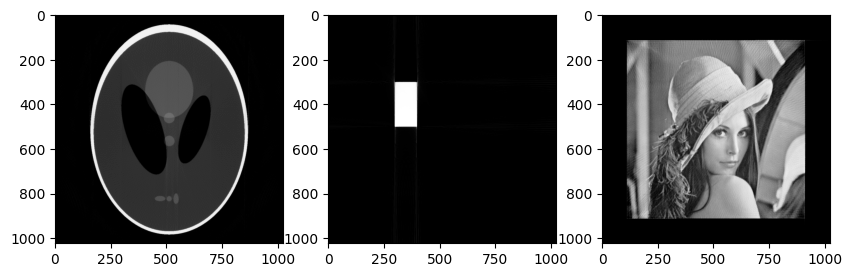

Original:


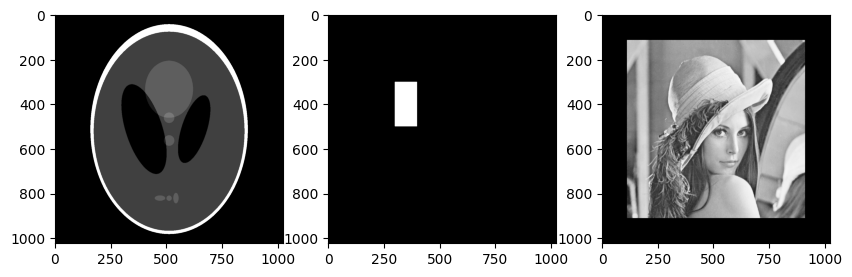

In [ ]:
print ('Reconstructed:')
plt.figure(figsize=(10,7))
ImReconstrL = []
for k in range(3):
    plt.subplot(1,3,k+1)
    f_rec = np.clip(radon_inv(ImRadonL[k]), 0, 1) # clip the values to the interval [0,1]
    ImReconstrL.append(f_rec)
    plt.imshow(f_rec, cmap=plt.cm.Greys_r)
plt.show()

print ('Original:')
plt.figure(figsize=(10,7))
for k in range(3):
    plt.subplot(1,3,k+1)
    plt.imshow(ImOrigL[k], cmap=plt.cm.Greys_r)
plt.show()

Compute the mean reconstruction error and compare the cumulative distribution functions for values in the original and reconstructed images:

Image 0 mean reconstruction error: 0.000080
Image 1 mean reconstruction error: 0.002930
Image 2 mean reconstruction error: 0.000206


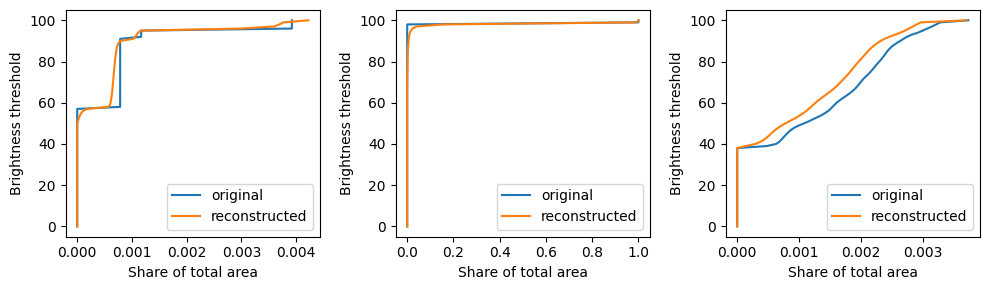

In [ ]:
perc = np.arange(101)

plt.figure(figsize=(10,3))
for k in range(3):
    print ('Image %d mean reconstruction error: %f' %(k, np.mean(np.abs(ImReconstrL[k]-ImOrigL[k]))))
    plt.subplot(1,3,k+1)
    plt.plot(np.percentile(ImOrigL[k], perc), perc, label='original')
    plt.plot(np.percentile(ImReconstrL[k], perc), perc, label='reconstructed')
    plt.xlabel('Share of total area')
    plt.ylabel('Brightness threshold')
    plt.legend(loc='best')

plt.tight_layout()
plt.show()